In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import librosa
import pydub
import os
import glob

In [9]:
class Clip:
    """A single 5-sec long recording."""
    
    RATE = 44100   # All recordings in ESC are 44.1 kHz
    FRAME = 512    # Frame size in samples
    
    class Audio:
        """The actual audio data of the clip.
        
            Uses a context manager to load/unload the raw audio data. This way clips
            can be processed sequentially with reasonable memory usage.
        """
        
        def __init__(self, path):
            self.path = path
        
        def __enter__(self):
            # Actual recordings are sometimes not frame accurate, so we trim/overlay to exactly 5 seconds
            self.data = pydub.AudioSegment.silent(duration=5000)
            self.data = self.data.overlay(pydub.AudioSegment.from_file(self.path)[0:5000])
            self.raw = (np.frombuffer(self.data._data, dtype="int16") + 0.5) / (0x7FFF + 0.5)   # convert to float
            return(self)
        
        def __exit__(self, exception_type, exception_value, traceback):
            if exception_type is not None:
                print(exception_type, exception_value, traceback)
            del self.data
            del self.raw
        
    def __init__(self, filename):
        self.filename = os.path.basename(filename)
        self.path = os.path.abspath(filename)        
        self.directory = os.path.dirname(self.path)
        self.category = self.directory.split('/')[-1]
        
        self.audio = Clip.Audio(self.path)
        
        with self.audio as audio:
            self._compute_mfcc(audio)    
            self._compute_zcr(audio)

    # LEGACY CODE      
    # def _compute_mfcc(self, audio):
    #     # MFCC computation with default settings (2048 FFT window length, 512 hop length, 128 bands)
    #     self.melspectrogram = librosa.feature.melspectrogram(audio.raw, sr=Clip.RATE, hop_length=Clip.FRAME)
    #     self.logamplitude = librosa.logamplitude(self.melspectrogram)
    #     self.mfcc = librosa.feature.mfcc(S=self.logamplitude, n_mfcc=13).transpose()
    
    def _compute_mfcc(self, audio):
        # MFCC computation with default settings (2048 FFT window length, 512 hop length, 128 bands)
        self.melspectrogram = librosa.feature.melspectrogram(y=audio.raw, sr=Clip.RATE, hop_length=Clip.FRAME)
        self.logamplitude = librosa.amplitude_to_db(self.melspectrogram, ref=np.max)
        self.mfcc = librosa.feature.mfcc(S=self.logamplitude, n_mfcc=13).transpose()

            
    def _compute_zcr(self, audio):
        # Zero-crossing rate
        self.zcr = []
        frames = int(np.ceil(len(audio.data) / 1000.0 * Clip.RATE / Clip.FRAME))
        
        for i in range(0, frames):
            frame = Clip._get_frame(audio, i)
            self.zcr.append(np.mean(0.5 * np.abs(np.diff(np.sign(frame)))))

        self.zcr = np.asarray(self.zcr)
            
    @classmethod
    def _get_frame(cls, audio, index):
        if index < 0:
            return None
        return audio.raw[(index * Clip.FRAME):(index+1) * Clip.FRAME]
    
    def __repr__(self):
        return '<{0}>'.format(self.filename)

In [7]:
import seaborn as sb
sb.set(style="white", palette="muted")

In [8]:
import random
random.seed(20150420)

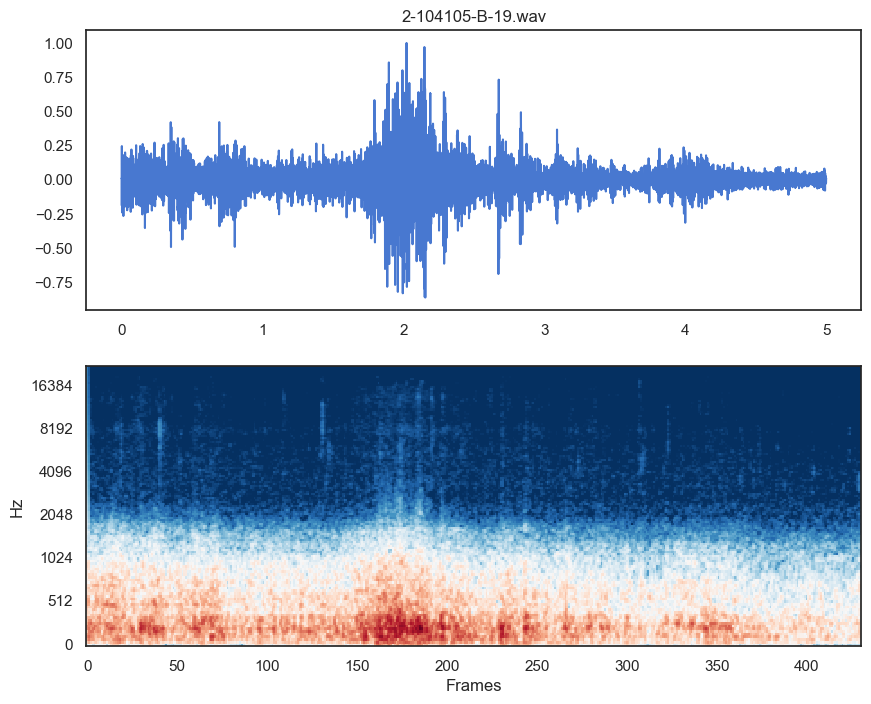

In [10]:
import IPython.display

# all_recordings = glob.glob('ESC-50-master/audio/*.wav')
# ESC-50-master\audio\2-104105-B-19.wav
all_recordings = glob.glob('ESC-50-master/audio/2-104105-B-19.wav')
clip = Clip(all_recordings[random.randint(0, len(all_recordings) - 1)])    

with clip.audio as audio:
    plt.figure(figsize=(10, 8))
    plt.subplot(2, 1, 1)
    plt.title('{0}'.format(clip.filename))
    plt.plot(np.arange(0, len(audio.raw)) / 44100.0, audio.raw)
   
    plt.subplot(2, 1, 2)
    librosa.display.specshow(librosa.power_to_db(clip.melspectrogram, ref=np.max), sr=44100, x_axis='frames', y_axis='mel', cmap='RdBu_r')

    # change the height of the figure

IPython.display.Audio(filename=clip.path, rate=Clip.RATE)    


In [11]:
esc_csv = pd.read_csv('ESC-50-master/meta/esc50.csv')
esc_csv.head()

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


In [12]:
# target represents the class of each audio
def load_dataset(name):
    """Load all dataset recordings into a nested list."""
    # 50 classes and 10 clips for each class
    clips = []

    for i in range(50):
      class_clips = []
      for clip_filename in esc_csv[esc_csv["target"] == i]["filename"]:
        class_clips.append(Clip('{0}/{1}'.format(name, clip_filename)))
      print('All {0}/50 class recordings loaded.'.format(i+1))   
      clips.append(class_clips)
    return clips

clips_50 = load_dataset('ESC-50-master/audio')


All 1/50 class recordings loaded.
All 2/50 class recordings loaded.
All 3/50 class recordings loaded.
All 4/50 class recordings loaded.
All 5/50 class recordings loaded.
All 6/50 class recordings loaded.
All 7/50 class recordings loaded.
All 8/50 class recordings loaded.
All 9/50 class recordings loaded.
All 10/50 class recordings loaded.
All 11/50 class recordings loaded.
All 12/50 class recordings loaded.
All 13/50 class recordings loaded.
All 14/50 class recordings loaded.
All 15/50 class recordings loaded.
All 16/50 class recordings loaded.
All 17/50 class recordings loaded.
All 18/50 class recordings loaded.
All 19/50 class recordings loaded.
All 20/50 class recordings loaded.
All 21/50 class recordings loaded.
All 22/50 class recordings loaded.
All 23/50 class recordings loaded.
All 24/50 class recordings loaded.
All 25/50 class recordings loaded.
All 26/50 class recordings loaded.
All 27/50 class recordings loaded.
All 28/50 class recordings loaded.
All 29/50 class recordings lo

In [13]:
def add_subplot_axes(ax, position):
    box = ax.get_position()
    
    position_display = ax.transAxes.transform(position[0:2])
    position_fig = plt.gcf().transFigure.inverted().transform(position_display)
    x = position_fig[0]
    y = position_fig[1]
    
    return plt.gcf().add_axes([x, y, box.width * position[2], box.height * position[3]])

In [14]:
def plot_clip_overview(clip, ax):
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax_waveform = add_subplot_axes(ax, [0.0, 0.7, 1.0, 0.3])
    ax_spectrogram = add_subplot_axes(ax, [0.0, 0.0, 1.0, 0.7])
    
    with clip.audio as audio:
        ax_waveform.plot(np.arange(0, len(audio.raw)) / float(Clip.RATE), audio.raw)
        ax_waveform.get_xaxis().set_visible(False)
        ax_waveform.get_yaxis().set_visible(False)
        ax_waveform.set_title('{0} \n {1}'.format(clip.category, clip.filename), {'fontsize': 8}, y=1.03)

        librosa.display.specshow(librosa.power_to_db(clip.melspectrogram, ref=np.max), sr=44100, x_axis='frames', y_axis='mel', cmap='RdBu_r')
        ax_spectrogram.get_xaxis().set_visible(False)
        ax_spectrogram.get_yaxis().set_visible(False)
        ax_spectrogram.set_facecolor('w')


In [19]:
np.array(clips_50)

50

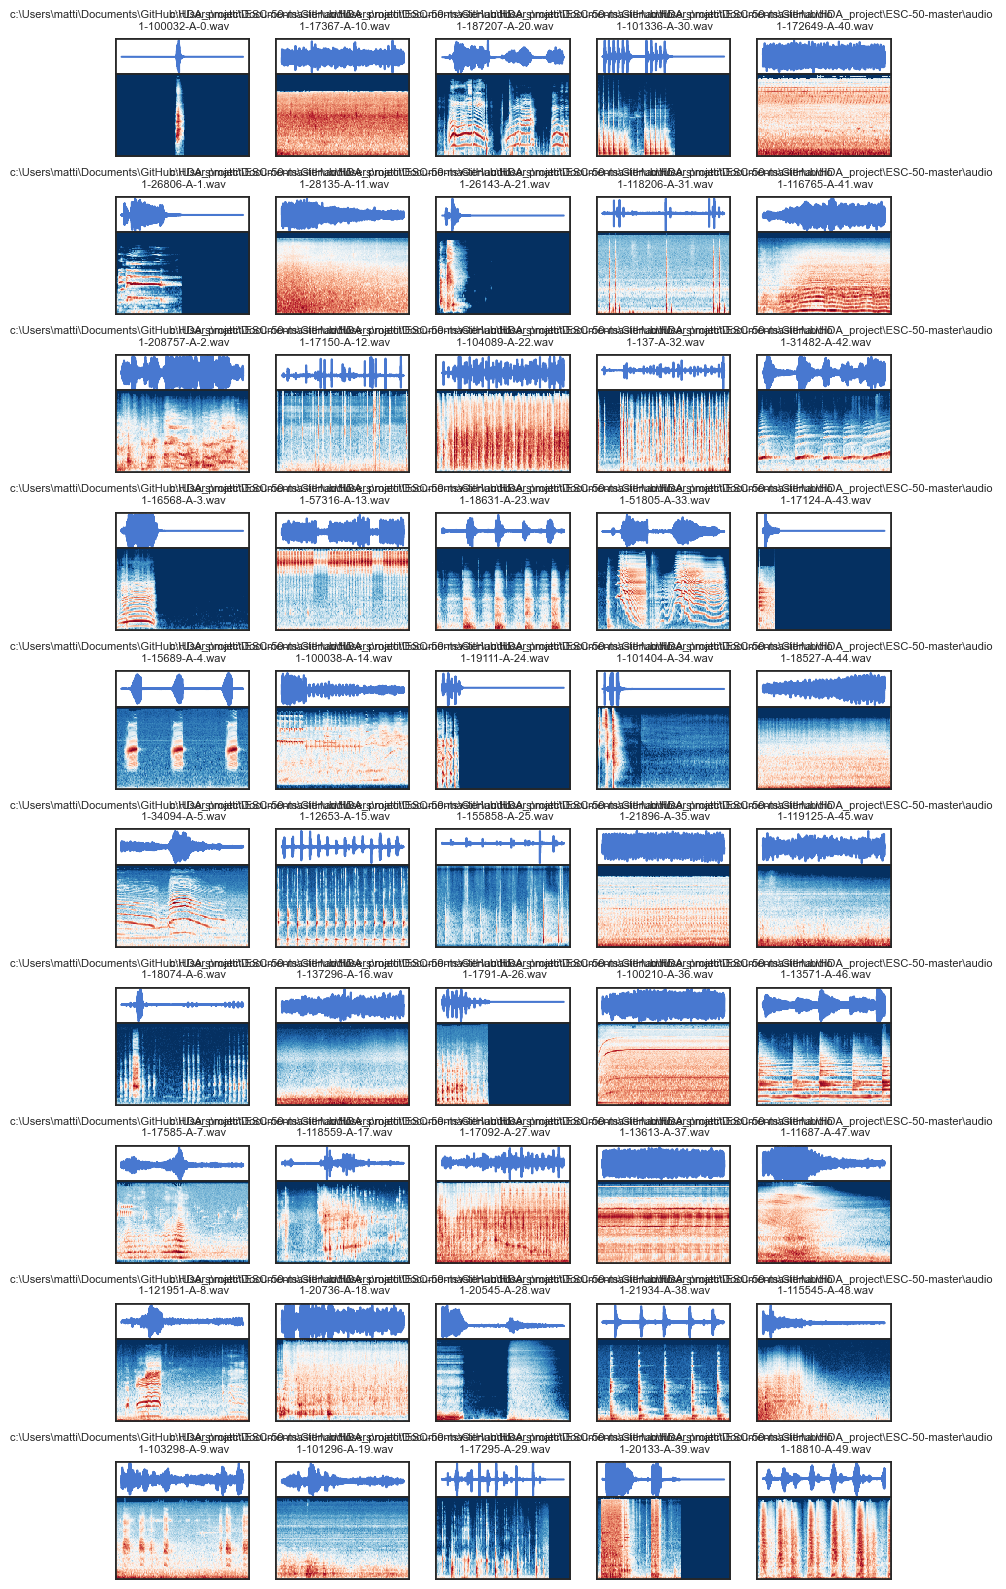

In [15]:
# Praticamente clips è un array da 50 arrays ciascuno dei quali contiene 40 clips
# in questo momento ho sbagliato e ho diviso nelle 5 categorie e non per classi

f, axes = plt.subplots(10, 5, figsize=(5 * 2, 10 * 2), sharex=True, sharey=True)
f.subplots_adjust(hspace = 0.35)

for row in range(0, 10):
    for col in range(0, 5):
        plot_clip_overview(clips_50[col * 10 + row][0], axes[row, col])

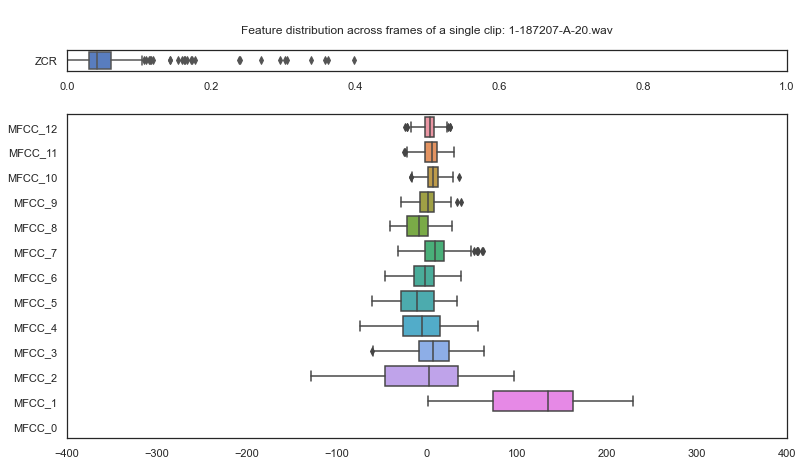

In [104]:
def plot_single_clip(clip):
    col_names = list('MFCC_{}'.format(i) for i in range(np.shape(clip.mfcc)[1]))
    mod_mfcc = librosa.feature.mfcc(S=librosa.power_to_db(clip.melspectrogram, ref=np.max), n_mfcc=13).transpose()
    MFCC = pd.DataFrame(mod_mfcc[:, :], columns=col_names)

    f = plt.figure(figsize=(10, 6))
    ax = f.add_axes([0.0, 0.0, 1.0, 1.0])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_frame_on(False)

    ax_mfcc = add_subplot_axes(ax, [0.0, 0.0, 1.0, 0.75])
    ax_mfcc.set_xlim(-400, 400)
    ax_zcr = add_subplot_axes(ax, [0.0, 0.85, 1.0, 0.05])
    ax_zcr.set_xlim(0.0, 1.0)

    plt.title('Feature distribution across frames of a single clip: {0}'.format(clip.filename), y=1.5)
    sb.boxplot(MFCC, orient='h', order=list(reversed(MFCC.columns)), ax=ax_mfcc)
    sb.boxplot(pd.DataFrame(clip.zcr, columns=['ZCR']), orient='h', ax=ax_zcr)
    
plot_single_clip(clips_50[20][0])